Notebook commun pour le projet


Groupe Emission:

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import numba as nb
import cython as cy
import scipy
import const
import mpmath



Retour point par point sur les différentes fonctions définies et vérification de leur cohérence:


Définition du paramètre $\Gamma$ avec les fonctions de Bessel et $\xi$

On a d'après l'équation (12):
$$ \Gamma = \frac{K_{3}(\xi)}{K_{2}(\xi)} - \frac{1}{\xi}    $$
Sachant que par analyse dimensionnelle $\xi$ est sans unité

In [5]:
#Définition des fonctions de Bessel de première espèce (avec une limite finie en 0)
from scipy.special import kv
K1p = lambda x: mpmath.besselk(1,x)
K2p = lambda x: mpmath.besselk(2,x)
K3p = lambda x: mpmath.besselk(3,x)

K1 = np.vectorize(K1p)
K2 = np.vectorize(K2p)
K3 = np.vectorize(K3p)



0.00404461344545216


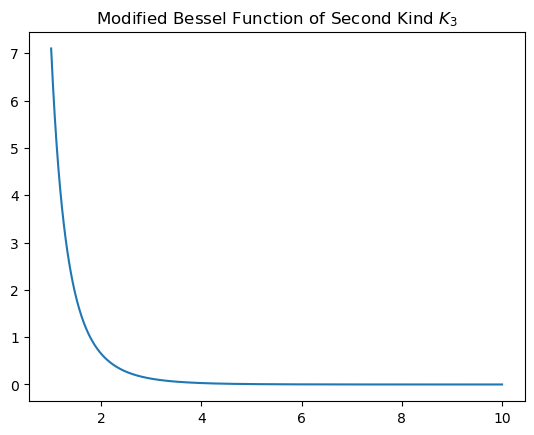

In [4]:
test1 = np.linspace(1, 10,1000)
plt.plot(test1, K3(test1))
plt.title('Modified Bessel Function of Second Kind $K_{3}$')
plt.show()


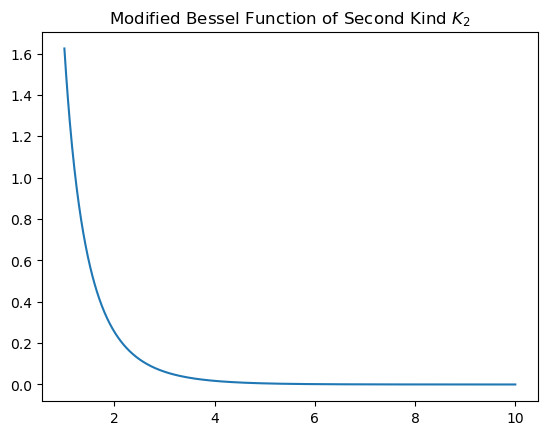

In [6]:
plt.plot(test1, K2(test1))
plt.title('Modified Bessel Function of Second Kind $K_{2}$')
plt.show()


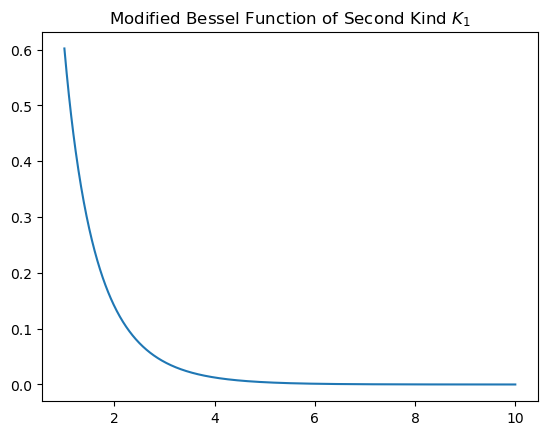

In [5]:
plt.plot(test1, K1(test1))
plt.title('Modified Bessel Function of Second Kind $K_{1}$')
plt.show()

In [8]:
def gamma_maj(ze):
    return float((K3(ze)/K2(ze) - 1/ze))

def gamma_chapeau_prime(ze):
    a = ze*(3*K3(ze) + K1(ze) - 4*K2(ze))
    return float(1 + 4*K2(ze)/a)


gamma_chapeau_prime(1)

1.4218623987391252

On utilise l'équation (5) pour déterminer directement en résolvant grâce à une valeur de gamma_sh donnée le $\zeta$ correspondant

C:\Users\quent\AppData\Local\Temp\ipykernel_24608\25113032.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((K3(ze)/K2(ze) - 1/ze))
C:\Users\quent\AppData\Local\Temp\ipykernel_24608\25113032.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(1 + 4*K2(ze)/a)


Text(0.5, 1.0, '$\\zeta$ en fonction de $\\Gamma_{sh}$')

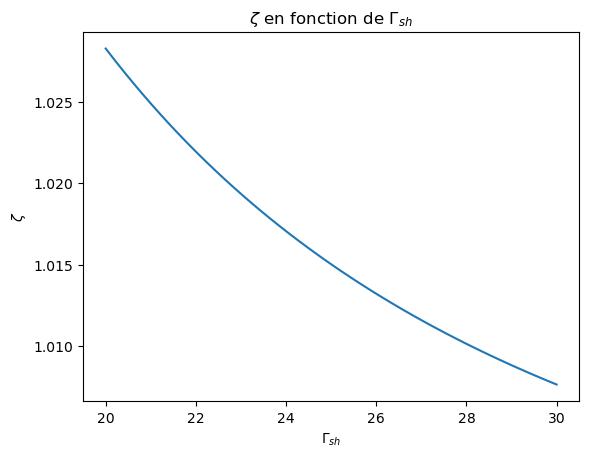

In [22]:
#On cherche la valeur de zêta en résolavant l'équation (5)

def eq(gamma_sh,ze):
    a = (gamma_maj(ze) + 1)*(1 + gamma_chapeau_prime(ze)*(gamma_maj(ze) - 1))**2
    b = 2 + gamma_chapeau_prime(ze)*(2 - gamma_chapeau_prime(ze)*(gamma_maj(ze) - 1))
    return gamma_sh**2 - a/b


from scipy.optimize import fsolve

def sol(gamma_sh):
    def func(ze):
        return eq(gamma_sh, ze)
    solve = fsolve(func, 1)
    return solve[0]

gamme = np.linspace(20,30,50)
sol_vect = np.vectorize(sol)
y = sol_vect(gamme)
plt.plot(gamme,y)
plt.xlabel('$\Gamma_{sh}$')
plt.ylabel('$\zeta$')
plt.title('$\zeta$ en fonction de $\Gamma_{sh}$')



Text(0.5, 1.0, '$\\Gamma$ en fonction de $\\Gamma_{sh}$')

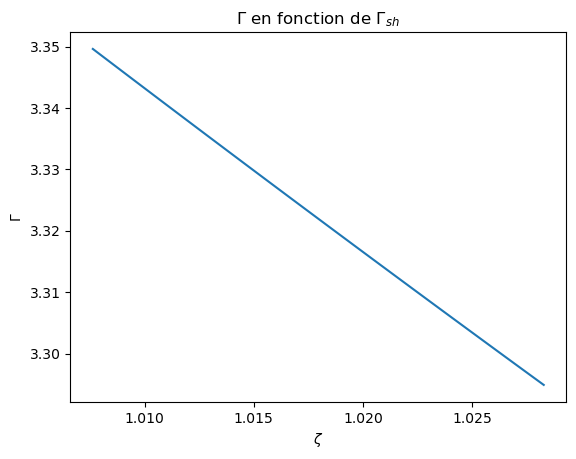

In [20]:
g_m = np.vectorize(gamma_maj)
y_p = g_m(y)
plt.plot(y,y_p)
plt.xlabel('$\zeta$')
plt.ylabel('$\Gamma$')
plt.title('$\Gamma$ en fonction de $\Gamma_{sh}$')

Text(0.5, 1.0, "$\\hat\\gamma_{'}$ en fonction de $\\zeta$")

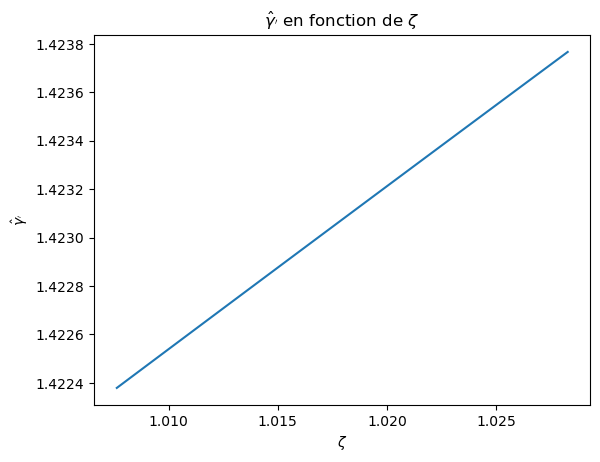

In [21]:
g_c = np.vectorize(gamma_chapeau_prime)
y_c_p = g_c(y)
plt.plot(y,y_c_p)
plt.xlabel('$\zeta$')
plt.ylabel('$\hat\gamma_{\'}$')
plt.title('$\hat\gamma_{\'}$ en fonction de $\zeta$')

Définition de la fonction $\frac{e_{i}}{n '}$ :

In [11]:
def n_prime(gamma_sh, n0):
    return 4*gamma_maj(sol(gamma_sh))*n0
def e_i_p(n0,gamma_sh):
    return const.m_p*((const.celer)**2)(gamma_maj(sol(gamma_sh)) - 1
                                        )*n_prime(n0,gamma_sh)

In [12]:
epsi_b = 4.12*(1/np.power(10,5))
def gamma_prime_c(n0,epsilon_B, gamma_sh,t):
    return (3 * const.m_e * const.celer* gamma_maj(sol(gamma_sh))) / (4 * const.sigma_T * 
                                                                      epsilon_B *e_i_p(gamma_sh) * t*n0)

def gamma_prime_m(p, gamma_sh):
    arg = ((p - 2)*const.m_p/(p - 1)*const.m_e)*const.epsi_e*(gamma_maj(sol(gamma_sh)) - 1)
    return np.max(1, arg)




Définition de la fonction B'(T):

In [13]:

def B_prime(epsilonB, gamma_sh,n0):
    return (np.sqrt(8*const.pi*epsilonB*e_i_p(gamma_maj,gamma_chapeau_prime, gamma_sh,n0)))

    



Calcul du coefficient p à partir des coefficients $\beta_{u}$ et $\beta_{d}$

In [14]:
def p(beta_u,beta_d):
    a = 3*beta_u - 2*beta_u*(beta_d**2) + beta_d**3
    b = beta_u - beta_d
    return a/b - 2

def n_prime_r(n0,gamma_sh, beta_u,beta_d):
    return n_prime(gamma_sh,n0)*min(1,((p(beta_u, beta_d) - 2)*const.m_p/(p(beta_u,beta_d) - 1)
                                       *const.m_e)*const.epsi_e*(gamma_maj(sol(gamma_sh)) - 1))

In [15]:
def nu_prime_m(epsilon_B, gamma_sh,n0,p ):
    return 3/16 * gamma_prime_m(p,gamma_sh)**2 * const.q_e*B_prime(epsilon_B, gamma_sh,n0) / (const.m_e * const.celer)

def nu_prime_c(n0,epsilon_B, t, gamma_sh):
    return 3/16 * gamma_prime_c(n0,epsilon_B,gamma_sh, t)**2 * const.q_e *B_prime(epsilon_B, gamma_sh, n0) / (const.m_e * const.celer)

Pour la fonction d'émission qui est définie dans le papier par les équations (24) et (25) la renormalisation nous donne:

$$ x = \frac{\nu'}{\nu_{m}'}$$
Pour déterminer le régime de refroidissement on définit un rapport 
$$ \kappa = \frac{\nu_{c}'(\epsilon_{B},t)}{\nu_{m}'(\epsilon_{B})}$$
on obtient donc:
Si $\kappa > 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}}$  pour  $x <1$} \\
\text{$x^{-(p-1)/2}$ pour  $1\leq x \leq \kappa$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $\kappa < x$}
\end{cases}
\]

Si $\kappa \leq 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}} \kappa^{-1/3}$  pour  $x <\kappa$} \\
\text{$\kappa^{1/2} x^{-1/2}$ pour  $\kappa\leq x < 1$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $1  \leq x$}
\end{cases}
\]

In [16]:
#Pour la fonction d'émission on renormalise tout:
epsi_b_gaussianJ = 2.44*(1/np.power(10,4))
epsi_b_hollow_coneJ = 4.12*(1/np.power(10,5))
epsi_b_SpindleJ = 6.60*(1/np.power(10,4))
#pour l'instant en première approximation on prend p = 2.05


def power_I(x,y):
    return 1/np.power(x,y)

#Rapport de comparaison pour les refroidissemts entre nu_prim_c et nu_prim_m
def Kappa(n0,epsilon_B,t,gamma_sh):
    return nu_prime_c(n0, epsilon_B, gamma_sh,t)/nu_prime_m(epsilon_B, gamma_sh, n0)


In [17]:
def FastcEmission(n0,x, Kappa,p,epsilon_B,t,gamma_sh):
    if x > Kappa(n0,epsilon_B,t,gamma_sh):
        return np.power(Kappa(n0,epsilon_B,t,gamma_sh),-1/3)*np.power(x,1/3)
    elif x >= Kappa(n0,epsilon_B,t,gamma_sh) and x <1:
        return np.power(Kappa(n0,epsilon_B,t,gamma_sh),1/2)*power_I(x,-1/2)
    else:
        power_I(Kappa(n0,epsilon_B,t,gamma_sh),-1/2)*power_I(x,-p/2)


In [18]:
#Cas du slow-cooling
def SlowcEmission(x,Kappa,p,epsilon_B,t,gamma_sh,n0):
    if x < 1:
        return np.power(x,1/3)
    elif x>=1 and x < Kappa(n0,epsilon_B,t,gamma_sh):
        return power_I(x,-(p-1)/2)
    else:
        return power_I(Kappa(n0,epsilon_B,t,gamma_sh),-1/2)*power_I(-p/2)




#Fonction d'émission
def Emission_function(n0,Kappa,x,epsilon_B,t,gamma_sh,p):
    if Kappa(n0,epsilon_B,t,gamma_sh) > 1:
        return SlowcEmission(x,Kappa,p,epsilon_B,t,gamma_sh,n0)
    else:
        return FastcEmission(n0,x, Kappa,p,epsilon_B,t,gamma_sh)

#On applique le facteur de renormalisation
def fact_denorm(beta_u,beta_d,n0,gamma_sh,epsilon_b):
    return 0.88*(256*(p(beta_u,beta_d) - 1)*(const.q_e**3)*n_prime_r(n0,gamma_sh,beta_u,beta_d)
                 *B_prime(epsilon_b,gamma_sh,n0)/27*(3*(p(beta_u,beta_d) - 1)*const.m_e*(const.celer**2)))